All libraries imported successfully
Data Loaded:
   Training samples: 888
   Test samples: 222
   Features: 16
   Target range: [63.80, 81.80]
Model Configurations:
   KNN
   DECISION_TREE
   RANDOM_FOREST
   SVR
   RIDGE
   NEURAL_NETWORK
TRAINING BASE MODELS WITH 10-FOLD CROSS-VALIDATION

Training KNN...
   KNN Trained
      10-Fold CV RMSE: 2.3098 ± 0.8355
      Test RMSE: 2.6395
      Test MAE: 2.1319
      Test R²: 0.0705
      Best Params: {'n_neighbors': 9, 'weights': 'distance'}

Training DECISION_TREE...
   DECISION_TREE Trained
      10-Fold CV RMSE: 2.3510 ± 0.8542
      Test RMSE: 2.6760
      Test MAE: 2.1251
      Test R²: 0.0446
      Best Params: {'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}

Training RANDOM_FOREST...
   RANDOM_FOREST Trained
      10-Fold CV RMSE: 2.2170 ± 0.8445
      Test RMSE: 2.5112
      Test MAE: 2.0023
      Test R²: 0.1587
      Best Params: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}

Training SVR...
   SV

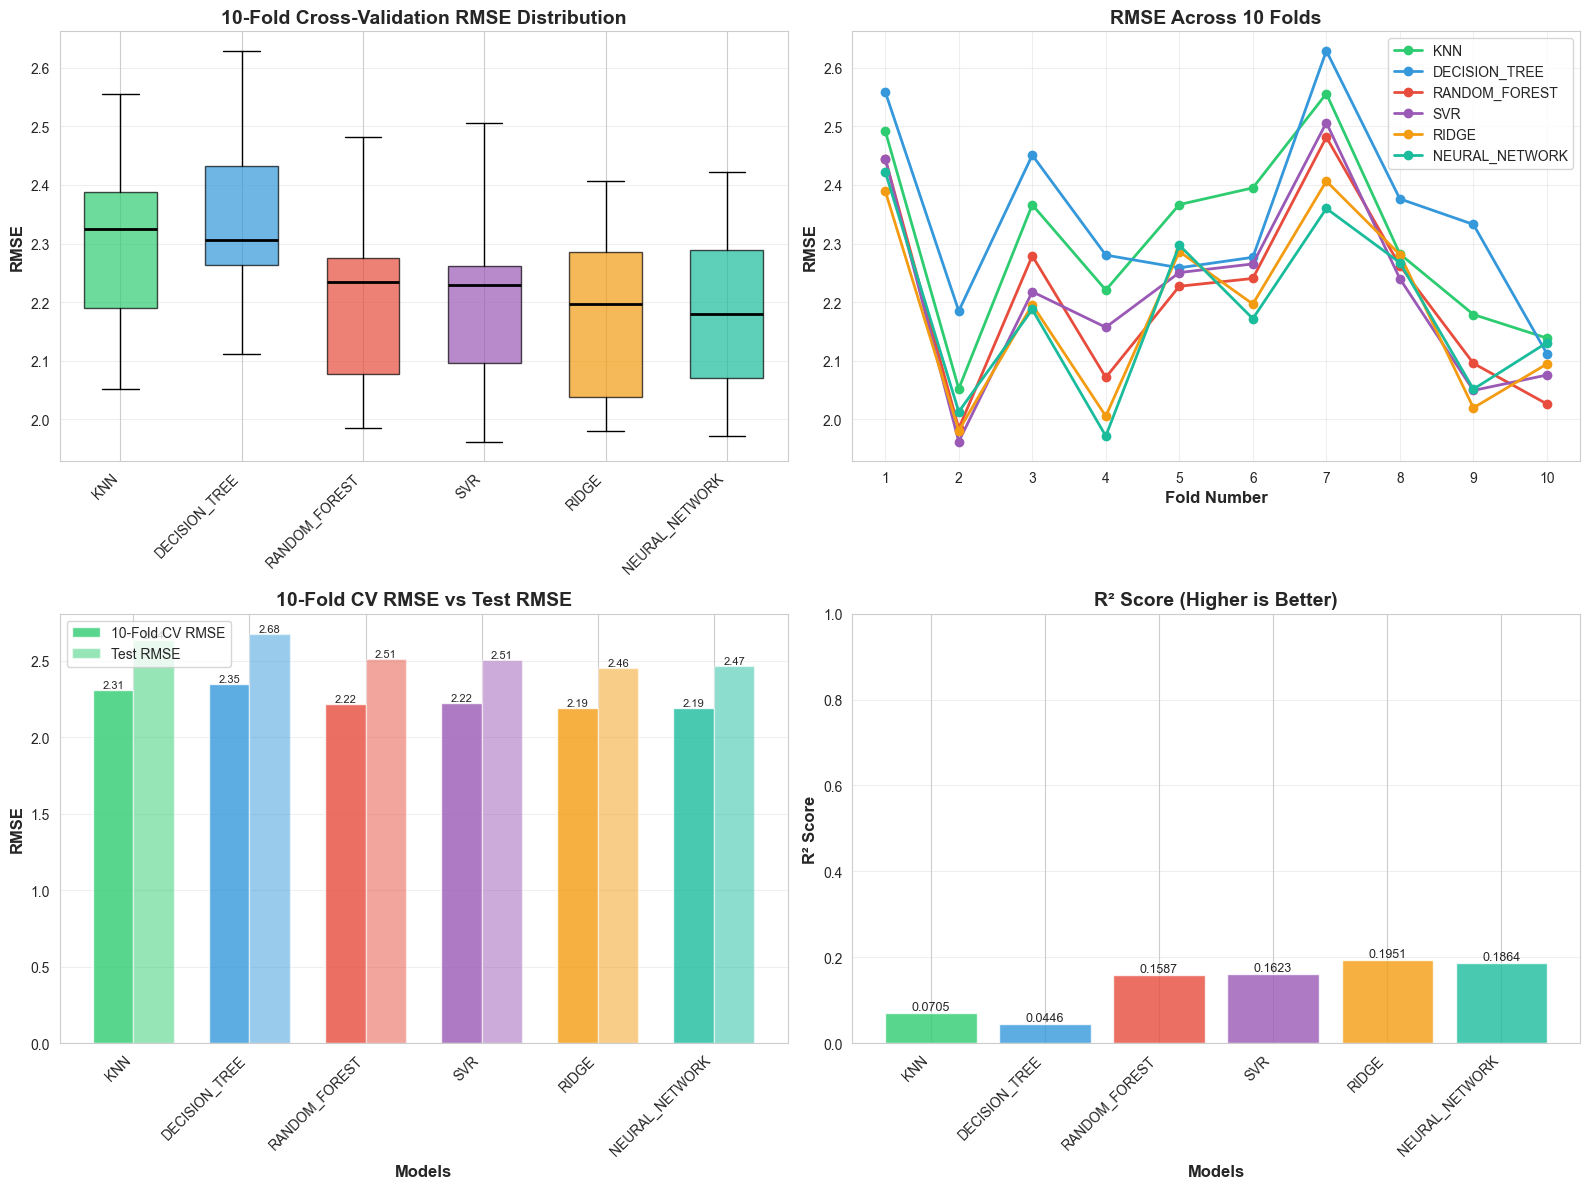


MODEL PERFORMANCE SUMMARY


,Model,CV RMSE,Test RMSE,Test MAE,Test R²
0,KNN,2.3098,2.6395,2.1319,0.0705
1,DECISION_TREE,2.3510,2.6760,2.1251,0.0446
2,RANDOM_FOREST,2.2170,2.5112,2.0023,0.1587
3,SVR,2.2226,2.5058,2.0196,0.1623
4,RIDGE,2.1906,2.4564,1.9876,0.1951
5,NEURAL_NETWORK,2.1919,2.4695,2.0038,0.1864



Best Model: RIDGE
   Test RMSE: 2.4564
   Test R²: 0.1951

DETAILED TEST RESULTS

KNN
   Test RMSE: 2.6395
   Test MAE:  2.1319
   Test R²:   0.0705
   10-Fold CV RMSE: 2.3098 ± 0.6980
   Mean Residual: -0.0796
   Std Residual:  2.6383

DECISION_TREE
   Test RMSE: 2.6760
   Test MAE:  2.1251
   Test R²:   0.0446
   10-Fold CV RMSE: 2.3510 ± 0.7297
   Mean Residual: -0.0018
   Std Residual:  2.6760

RANDOM_FOREST
   Test RMSE: 2.5112
   Test MAE:  2.0023
   Test R²:   0.1587
   10-Fold CV RMSE: 2.2170 ± 0.7132
   Mean Residual: 0.0061
   Std Residual:  2.5112

SVR
   Test RMSE: 2.5058
   Test MAE:  2.0196
   Test R²:   0.1623
   10-Fold CV RMSE: 2.2226 ± 0.7180
   Mean Residual: 0.0971
   Std Residual:  2.5039

RIDGE
   Test RMSE: 2.4564
   Test MAE:  1.9876
   Test R²:   0.1951
   10-Fold CV RMSE: 2.1906 ± 0.6501
   Mean Residual: 0.0589
   Std Residual:  2.4557

NEURAL_NETWORK
   Test RMSE: 2.4695
   Test MAE:  2.0038
   Test R²:   0.1864
   10-Fold CV RMSE: 2.1919 ± 0.6244
   Mean R

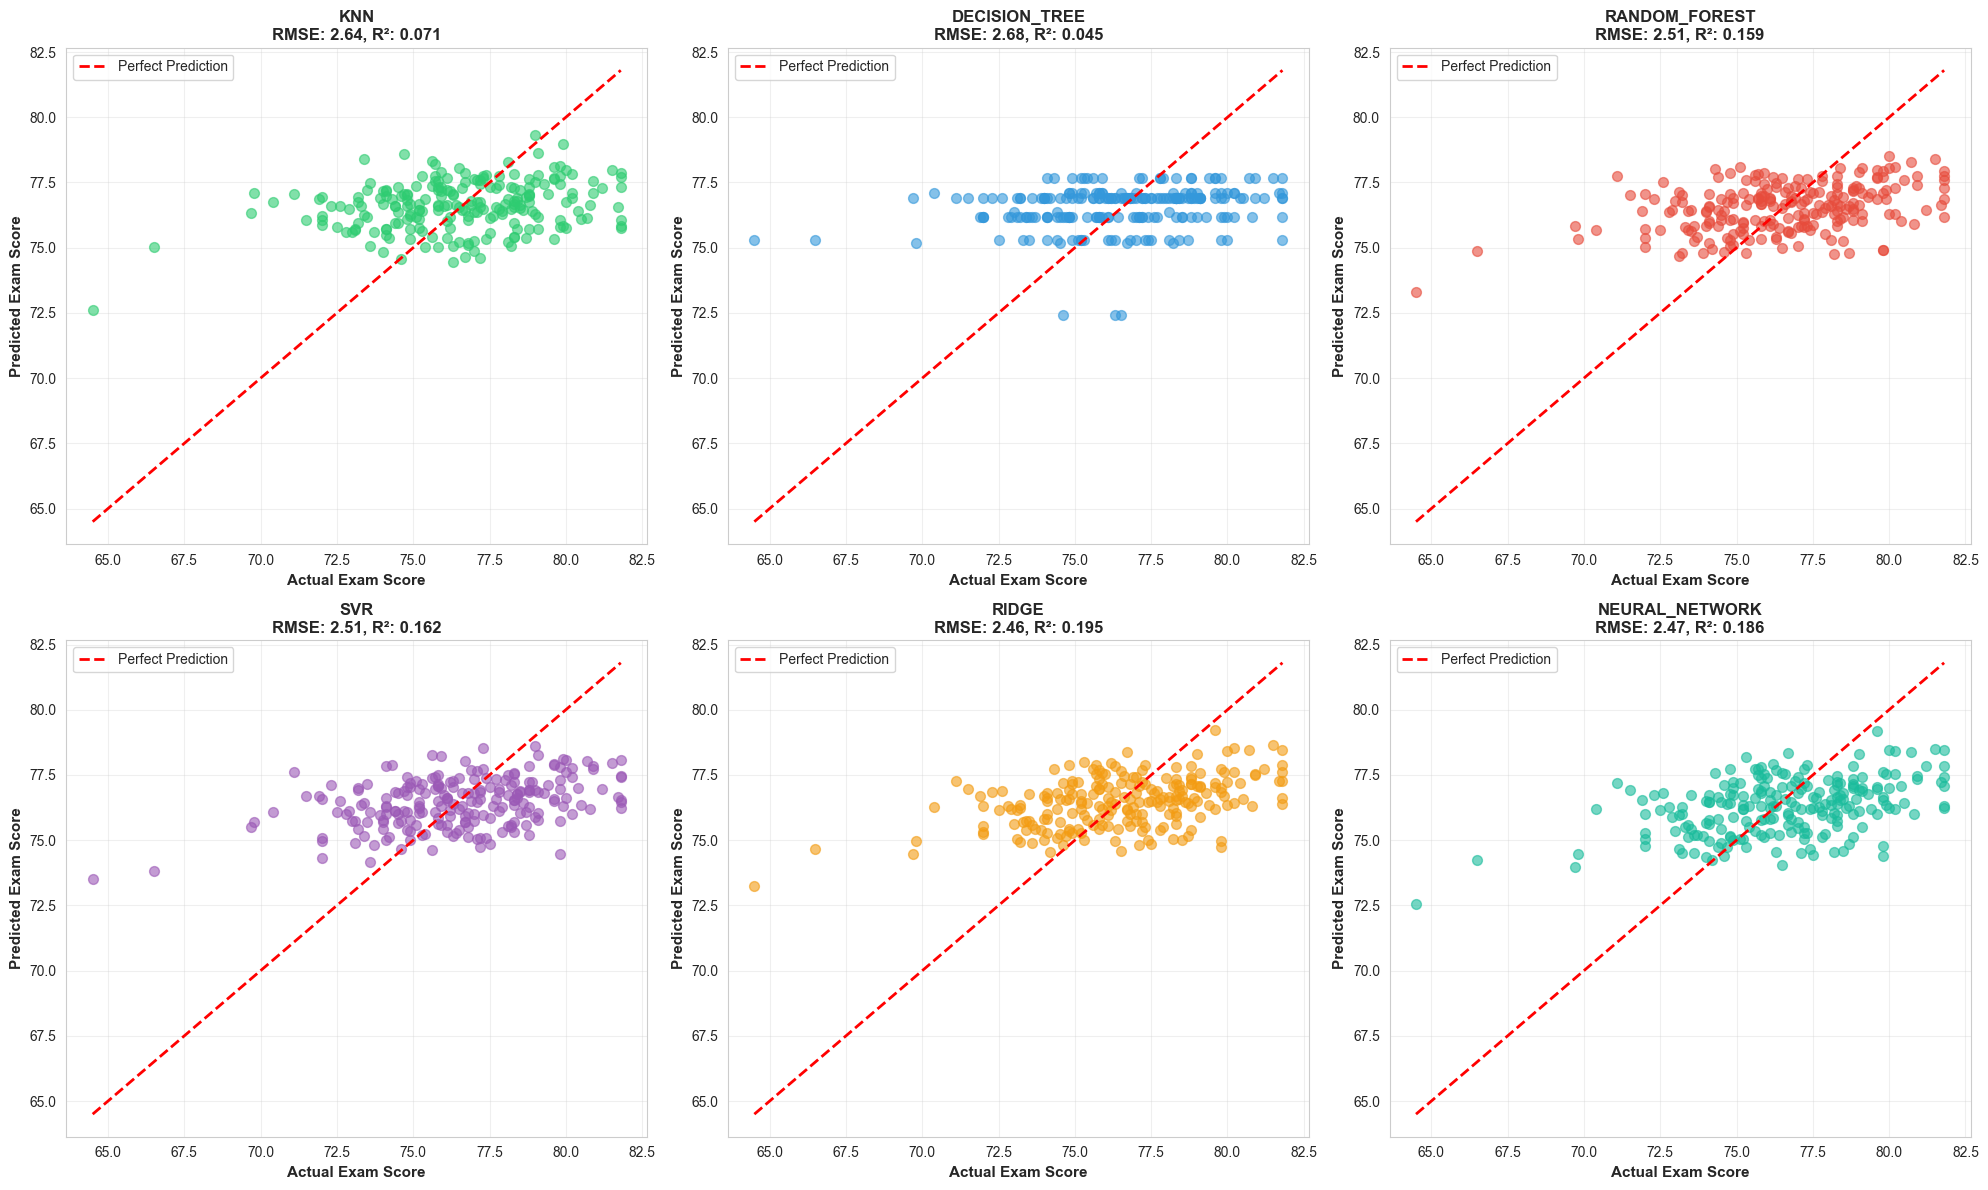


FEATURE IMPORTANCE ANALYSIS

DECISION_TREE - Top 10 Features:
           Feature  Importance
        StudyHours    0.280606
      ReviewCenter    0.264627
               GPA    0.108788
EnglishProficiency    0.103998
     SocialSupport    0.098580
       TestAnxiety    0.095677
  EmploymentStatus    0.047725
            Gender    0.000000
        Confidence    0.000000
        SleepHours    0.000000

RANDOM_FOREST - Top 10 Features:
           Feature  Importance
        StudyHours    0.123840
     MockExamScore    0.121880
       TestAnxiety    0.097990
               Age    0.096342
        SleepHours    0.076652
EnglishProficiency    0.069186
     SocialSupport    0.065093
               GPA    0.064652
        Confidence    0.058966
   MotivationScore    0.046534

Calculating permutation importance for remaining models...
   Processing KNN...

KNN - Top 10 Features (Permutation Importance):
           Feature  Importance
               Age    0.033826
     SocialSupport    0.02416

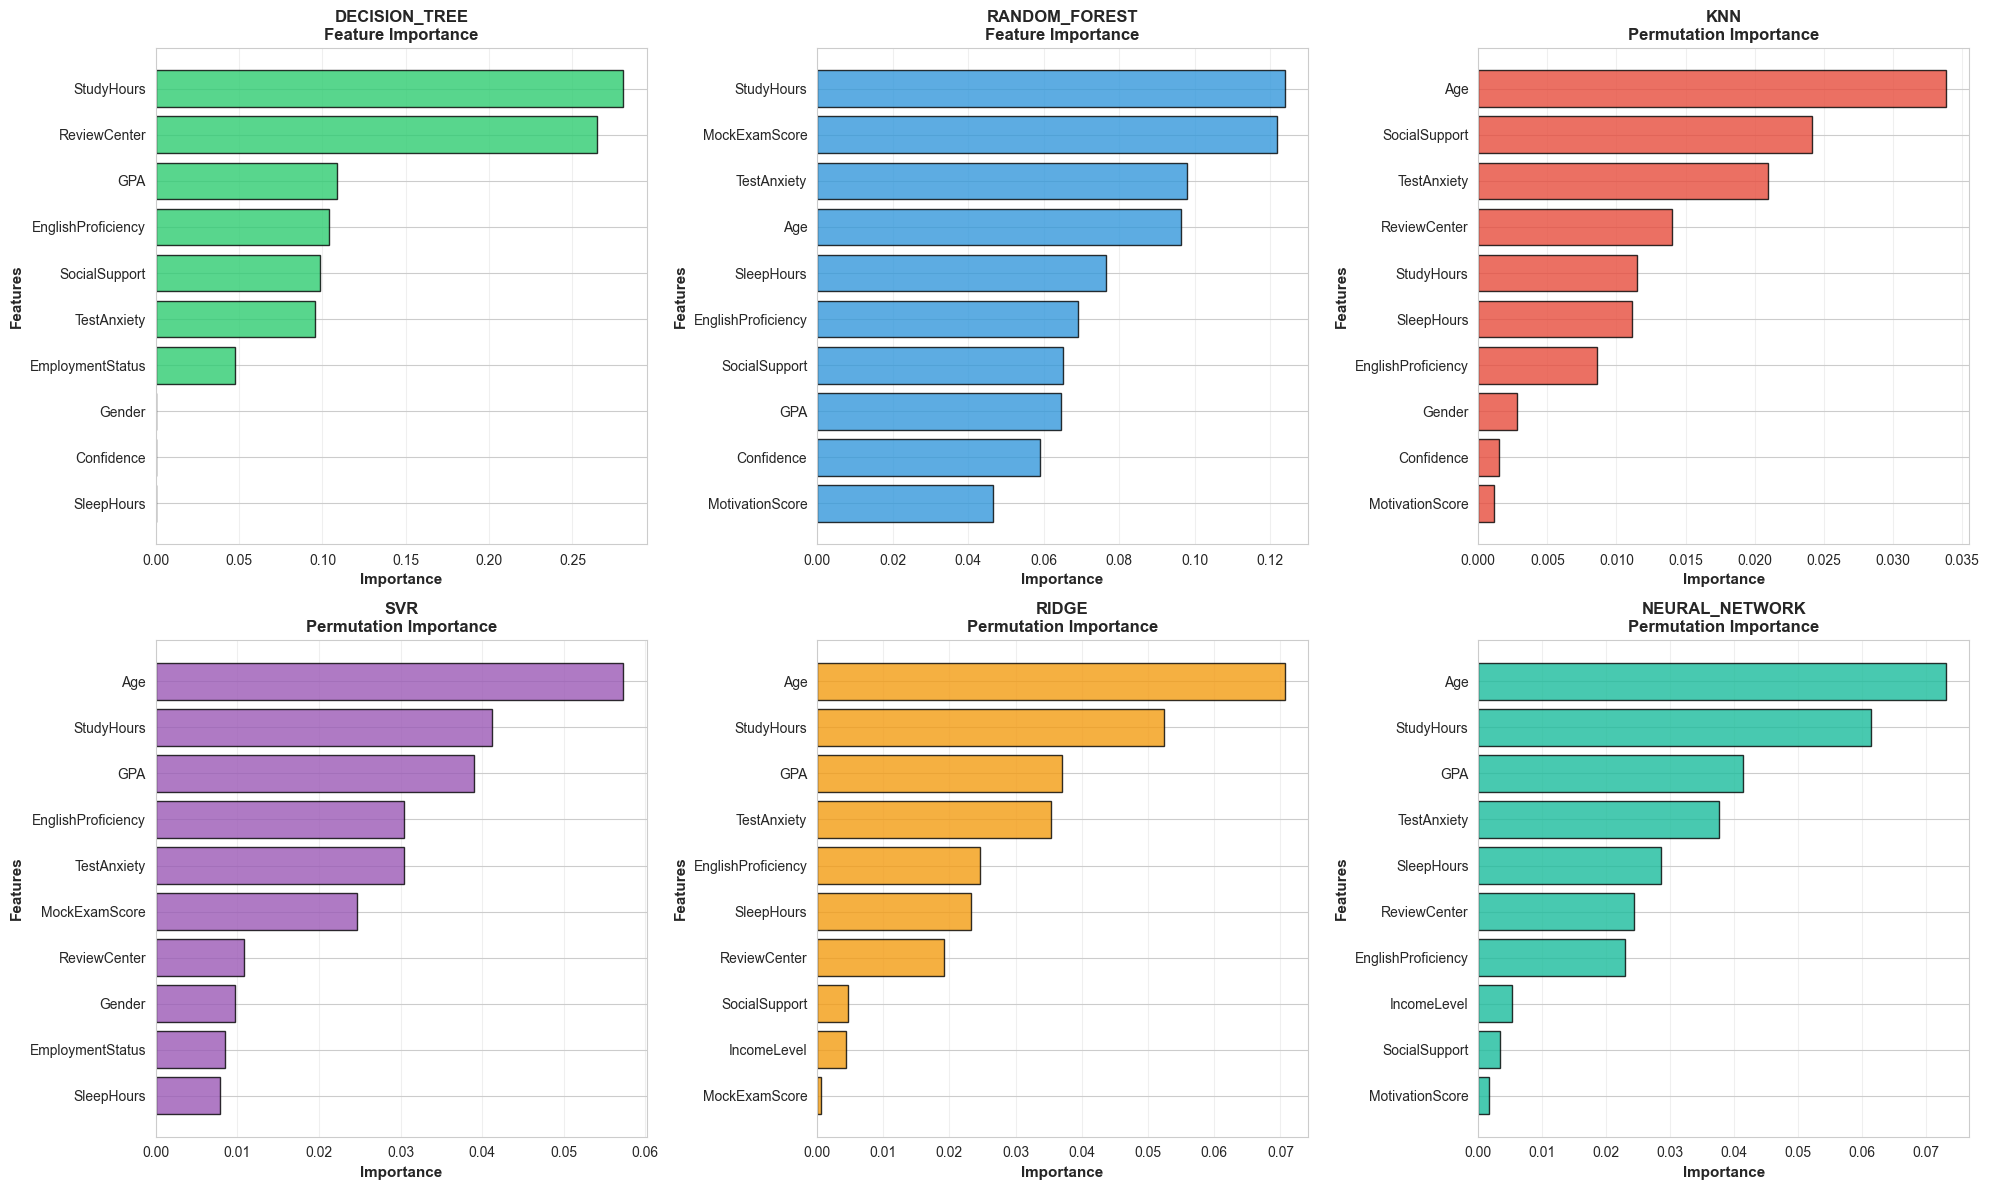


Saving feature importance data...
   Saved: ../saved_base_models/decision_tree_feature_importance.csv
   Saved: ../saved_base_models/random_forest_feature_importance.csv
   Saved: ../saved_base_models/knn_feature_importance.csv
   Saved: ../saved_base_models/svr_feature_importance.csv
   Saved: ../saved_base_models/ridge_feature_importance.csv
   Saved: ../saved_base_models/neural_network_feature_importance.csv

SAVING TRAINED MODELS
   Saved: knn_model.pkl
   Verified: knn_model.pkl
   Saved: decision_tree_model.pkl
   Verified: decision_tree_model.pkl
   Saved: random_forest_model.pkl
   Verified: random_forest_model.pkl
   Saved: svr_model.pkl
   Verified: svr_model.pkl
   Saved: ridge_model.pkl
   Verified: ridge_model.pkl
   Saved: neural_network_model.pkl
   Verified: neural_network_model.pkl

Models saved to saved_base_models/

CREATING AND SAVING PREPROCESSOR

Loading preprocessing components...
   Label encoders loaded
   Iterative imputer loaded
   Median imputer loaded
   S

In [2]:
# Cell 1: Imports
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("All libraries imported successfully")

# Cell 2: Load Preprocessed Data
X_train = np.load('../regression_processed_data/X_train.npy')
X_test = np.load('../regression_processed_data/X_test.npy')
y_train = np.load('../regression_processed_data/y_train.npy')
y_test = np.load('../regression_processed_data/y_test.npy')

print(f"Data Loaded:")
print(f"   Training samples: {X_train.shape[0]}")
print(f"   Test samples: {X_test.shape[0]}")
print(f"   Features: {X_train.shape[1]}")
print(f"   Target range: [{y_train.min():.2f}, {y_train.max():.2f}]")

# Cell 3: Define Model Configurations
model_configs = {
    'knn': {
        'model': KNeighborsRegressor(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }
    },
    'decision_tree': {
        'model': DecisionTreeRegressor(random_state=42),
        'params': {
            'max_depth': [3, 5, 7, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    },
    'random_forest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10]
        }
    },
    'svr': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1.0, 10.0],
            'epsilon': [0.01, 0.1, 0.2],
            'kernel': ['rbf']
        }
    },
    'ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1.0, 10.0, 100.0]
        }
    },
    'neural_network': {
        'model': MLPRegressor(random_state=42, max_iter=1000, early_stopping=True),
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
            'activation': ['relu', 'tanh'],
            'alpha': [0.0001, 0.001, 0.01],
            'learning_rate': ['constant', 'adaptive']
        }
    }
}

print("Model Configurations:")
for name in model_configs.keys():
    print(f"   {name.upper()}")

# Cell 4: Train Models with 10-Fold CV
results = {}
cv = KFold(n_splits=10, shuffle=True, random_state=42)

print("=" * 70)
print("TRAINING BASE MODELS WITH 10-FOLD CROSS-VALIDATION")
print("=" * 70)

for name, config in model_configs.items():
    print(f"\nTraining {name.upper()}...")
    
    grid_search = GridSearchCV(
        config['model'],
        config['params'],
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        return_train_score=True
    )
    
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    
    cv_results = grid_search.cv_results_
    best_index = grid_search.best_index_
    
    # Extract fold scores
    fold_scores = []
    for fold_idx in range(10):
        fold_key = f'split{fold_idx}_test_score'
        fold_scores.append(-cv_results[fold_key][best_index])
    
    cv_mean = np.mean(fold_scores)
    cv_std = np.std(fold_scores)
    cv_min = np.min(fold_scores)
    cv_max = np.max(fold_scores)
    cv_rmse = np.sqrt(cv_mean)
    
    # Test predictions
    y_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'model': best_model,
        'cv_mse_mean': cv_mean,
        'cv_mse_std': cv_std,
        'cv_mse_min': cv_min,
        'cv_mse_max': cv_max,
        'cv_rmse': cv_rmse,
        'cv_10fold_scores': fold_scores,
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'y_pred': y_pred,
        'best_params': grid_search.best_params_
    }
    
    print(f"   {name.upper()} Trained")
    print(f"      10-Fold CV RMSE: {cv_rmse:.4f} ± {np.sqrt(cv_std):.4f}")
    print(f"      Test RMSE: {test_rmse:.4f}")
    print(f"      Test MAE: {test_mae:.4f}")
    print(f"      Test R²: {test_r2:.4f}")
    print(f"      Best Params: {grid_search.best_params_}")

# Cell 5: Visualize 10-Fold CV Results
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

model_names = list(results.keys())
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6', '#f39c12', '#1abc9c']

# Plot 1: Box plot of 10-fold scores (RMSE)
fold_data = []
for name in model_names:
    for fold_idx, mse in enumerate(results[name]['cv_10fold_scores'], 1):
        fold_data.append({
            'Model': name.upper(),
            'Fold': fold_idx,
            'RMSE': np.sqrt(mse)
        })

fold_df = pd.DataFrame(fold_data)

box_positions = []
for idx, name in enumerate(model_names):
    model_data = fold_df[fold_df['Model'] == name.upper()]['RMSE']
    bp = axes[0, 0].boxplot([model_data], positions=[idx], widths=0.6,
                            patch_artist=True,
                            boxprops=dict(facecolor=colors[idx], alpha=0.7),
                            medianprops=dict(color='black', linewidth=2))
    box_positions.append(idx)

axes[0, 0].set_xticks(box_positions)
axes[0, 0].set_xticklabels([name.upper() for name in model_names], rotation=45, ha='right')
axes[0, 0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0, 0].set_title('10-Fold Cross-Validation RMSE Distribution', fontsize=14, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)

# Plot 2: Line plot showing each fold's performance
for idx, name in enumerate(model_names):
    fold_rmse = [np.sqrt(mse) for mse in results[name]['cv_10fold_scores']]
    axes[0, 1].plot(range(1, 11), fold_rmse, marker='o', linewidth=2,
                   label=name.upper(), color=colors[idx])

axes[0, 1].set_xlabel('Fold Number', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[0, 1].set_title('RMSE Across 10 Folds', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_xticks(range(1, 11))

# Plot 3: CV RMSE vs Test RMSE comparison
x = np.arange(len(model_names))
width = 0.35

cv_rmse_values = [results[name]['cv_rmse'] for name in model_names]
test_rmse_values = [results[name]['test_rmse'] for name in model_names]

bars1 = axes[1, 0].bar(x - width/2, cv_rmse_values, width, label='10-Fold CV RMSE',
                       color=colors, alpha=0.8)
bars2 = axes[1, 0].bar(x + width/2, test_rmse_values, width, label='Test RMSE',
                       color=colors, alpha=0.5)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=8)

axes[1, 0].set_xlabel('Models', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('RMSE', fontsize=12, fontweight='bold')
axes[1, 0].set_title('10-Fold CV RMSE vs Test RMSE', fontsize=14, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels([name.upper() for name in model_names], rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: R² Score comparison
r2_scores = [results[name]['test_r2'] for name in model_names]

bars = axes[1, 1].bar([name.upper() for name in model_names], r2_scores,
                      color=colors, alpha=0.8)

for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.4f}', ha='center', va='bottom', fontsize=9)

axes[1, 1].set_xlabel('Models', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[1, 1].set_title('R² Score (Higher is Better)', fontsize=14, fontweight='bold')
axes[1, 1].set_xticklabels([name.upper() for name in model_names], rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)
axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Cell 6: Performance Summary Table
summary_data = []
for name in model_names:
    summary_data.append({
        'Model': name.upper(),
        'CV RMSE': f"{results[name]['cv_rmse']:.4f}",
        'Test RMSE': f"{results[name]['test_rmse']:.4f}",
        'Test MAE': f"{results[name]['test_mae']:.4f}",
        'Test R²': f"{results[name]['test_r2']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 70)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 70)
display(summary_df)

best_model_name = min(results.items(), key=lambda x: x[1]['test_rmse'])[0]
print(f"\nBest Model: {best_model_name.upper()}")
print(f"   Test RMSE: {results[best_model_name]['test_rmse']:.4f}")
print(f"   Test R²: {results[best_model_name]['test_r2']:.4f}")

print("\n" + "=" * 70)
print("DETAILED TEST RESULTS")
print("=" * 70)

for name in model_names:
    y_pred = results[name]['y_pred']
    rmse = results[name]['test_rmse']
    mae = results[name]['test_mae']
    r2 = results[name]['test_r2']
    
    print(f"\n{name.upper()}")
    print(f"   Test RMSE: {rmse:.4f}")
    print(f"   Test MAE:  {mae:.4f}")
    print(f"   Test R²:   {r2:.4f}")
    print(f"   10-Fold CV RMSE: {results[name]['cv_rmse']:.4f} ± {results[name]['cv_mse_std']:.4f}")
    
    residuals = y_test - y_pred
    print(f"   Mean Residual: {np.mean(residuals):.4f}")
    print(f"   Std Residual:  {np.std(residuals):.4f}")

# Cell 6.5: Detailed Test Predictions Analysis
os.makedirs('../saved_base_models', exist_ok=True)

print("\n" + "=" * 70)
print("TEST PREDICTIONS ANALYSIS")
print("=" * 70)

for name in model_names:
    y_pred = results[name]['y_pred']
    
    prediction_details = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_test - y_pred,
        'Absolute_Error': np.abs(y_test - y_pred),
        'Percent_Error': np.abs((y_test - y_pred) / y_test) * 100
    })
    
    print(f"\n{name.upper()}")
    print(f"   Total Test Samples: {len(y_test)}")
    print(f"   Mean Absolute Error: {prediction_details['Absolute_Error'].mean():.4f}")
    print(f"   Median Absolute Error: {prediction_details['Absolute_Error'].median():.4f}")
    print(f"   Max Error: {prediction_details['Absolute_Error'].max():.4f}")
    print(f"   Min Error: {prediction_details['Absolute_Error'].min():.4f}")
    
    print(f"\n   First 10 predictions:")
    print(prediction_details.head(10).to_string(index=False))
    
    csv_file = f'../saved_base_models/{name}_test_predictions.csv'
    prediction_details.to_csv(csv_file, index=False)
    print(f"\n   Saved detailed predictions: {csv_file}")

# Cell 7: Prediction vs Actual Plots
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, name in enumerate(model_names):
    y_pred = results[name]['y_pred']
    
    # Scatter plot
    axes[idx].scatter(y_test, y_pred, alpha=0.6, s=50, color=colors[idx])
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 
                   'r--', linewidth=2, label='Perfect Prediction')
    
    # Metrics
    rmse = results[name]['test_rmse']
    r2 = results[name]['test_r2']
    
    axes[idx].set_xlabel('Actual Exam Score', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Predicted Exam Score', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{name.upper()}\nRMSE: {rmse:.2f}, R²: {r2:.3f}',
                       fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 8: Feature Importance Analysis
feature_names = json.load(open('../regression_processed_data/feature_names.json'))

print("\n" + "=" * 70)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

# Models that support feature importance
tree_based_models = ['decision_tree', 'random_forest']

# Dictionary to store feature importance for all models
feature_importance_dict = {}

# Calculate feature importance for tree-based models
for name in tree_based_models:
    if name in results:
        model = results[name]['model']
        importance = model.feature_importances_
        
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)
        
        feature_importance_dict[name] = feature_importance
        
        print(f"\n{name.upper()} - Top 10 Features:")
        print(feature_importance.head(10).to_string(index=False))

# Calculate permutation importance for other models
other_models = ['knn', 'svr', 'ridge', 'neural_network']

print("\nCalculating permutation importance for remaining models...")
for name in other_models:
    if name in results:
        print(f"   Processing {name.upper()}...")
        model = results[name]['model']
        
        # Calculate permutation importance
        perm_importance = permutation_importance(
            model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
        )
        
        feature_importance = pd.DataFrame({
            'Feature': feature_names,
            'Importance': perm_importance.importances_mean
        }).sort_values('Importance', ascending=False)
        
        feature_importance_dict[name] = feature_importance
        
        print(f"\n{name.upper()} - Top 10 Features (Permutation Importance):")
        print(feature_importance.head(10).to_string(index=False))

# Visualize feature importance for all models
num_models = len(feature_importance_dict)
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (name, importance_df) in enumerate(feature_importance_dict.items()):
    top_features = importance_df.head(10)
    
    axes[idx].barh(top_features['Feature'], top_features['Importance'], 
                   color=colors[idx], edgecolor='black', alpha=0.8)
    axes[idx].set_xlabel('Importance', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Features', fontsize=11, fontweight='bold')
    
    importance_type = "Feature Importance" if name in tree_based_models else "Permutation Importance"
    axes[idx].set_title(f'{name.upper()}\n{importance_type}', 
                       fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

# Hide unused subplot
if num_models < 6:
    for idx in range(num_models, 6):
        axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Save feature importance to CSV
print("\nSaving feature importance data...")
for name, importance_df in feature_importance_dict.items():
    csv_file = f'../saved_base_models/{name}_feature_importance.csv'
    importance_df.to_csv(csv_file, index=False)
    print(f"   Saved: {csv_file}")

# Cell 9: Save Models
print("\n" + "=" * 70)
print("SAVING TRAINED MODELS")
print("=" * 70)

for name, data in results.items():
    model_path = f'../saved_base_models/{name}_model.pkl'
    try:
        with open(model_path, 'wb') as f:
            joblib.dump(data['model'], f, compress=3)
        print(f"   Saved: {name}_model.pkl")
        
        # Verify the saved model
        test_load = joblib.load(model_path)
        print(f"   Verified: {name}_model.pkl")
    except Exception as e:
        print(f"   ERROR saving {name}_model.pkl: {e}")

print("\nModels saved to saved_base_models/")

# Cell 10: Create and Save Preprocessor
import sys

# Ensure saved_ensemble_models directory exists
os.makedirs('../saved_ensemble_models', exist_ok=True)

models_path = os.path.abspath('..')
if models_path not in sys.path:
    sys.path.insert(0, models_path)

# Import with experimental flag
from sklearn.experimental import enable_iterative_imputer
from regression_preprocessor import RegressionPreprocessor

print("\n" + "=" * 70)
print("CREATING AND SAVING PREPROCESSOR")
print("=" * 70)

try:
    # Load the preprocessing components
    print("\nLoading preprocessing components...")
    
    label_encoders = joblib.load('../regression_processed_data/label_encoders.pkl')
    print("   Label encoders loaded")
    
    iterative_imputer = joblib.load('../regression_processed_data/iterative_imputer.pkl')
    print("   Iterative imputer loaded")
    
    median_imputer = joblib.load('../regression_processed_data/median_imputer.pkl')
    print("   Median imputer loaded")
    
    scaler = joblib.load('../regression_processed_data/scaler.pkl')
    print("   Scaler loaded")
    
    with open('../regression_processed_data/feature_names.json', 'r') as f:
        feature_names = json.load(f)
    print("   Feature names loaded")
    
    with open('../regression_processed_data/imputation_config.json', 'r') as f:
        imputation_config = json.load(f)
    print("   Imputation config loaded")
    
    # Create preprocessor with both imputers
    print("\nCreating preprocessor object...")
    preprocessor = RegressionPreprocessor(
        iterative_imputer=iterative_imputer,
        median_imputer=median_imputer,
        label_encoders=label_encoders,
        scaler=scaler,
        imputation_config=imputation_config
    )
    print(f"   Created: {preprocessor}")
    
    # Save preprocessor
    print("\nSaving preprocessor...")
    preprocessor_path = '../saved_ensemble_models/preprocessor.pkl'
    
    with open(preprocessor_path, 'wb') as f:
        joblib.dump(preprocessor, f, compress=3)
    
    # Verify the save was successful
    file_size = os.path.getsize(preprocessor_path)
    print(f"   Preprocessor saved: {preprocessor_path}")
    print(f"   File size: {file_size} bytes")
    
    # Test loading the preprocessor
    print("\nVerifying saved preprocessor...")
    test_load = joblib.load(preprocessor_path)
    print(f"   Preprocessor verified: {test_load}")
    print(f"   Feature names count: {len(test_load.get_feature_names())}")
    
    # Save feature names
    feature_names_path = '../saved_ensemble_models/feature_names.pkl'
    with open(feature_names_path, 'wb') as f:
        joblib.dump(feature_names, f, compress=3)
    print(f"   Feature names saved: {feature_names_path}")
    
    # Save imputation config copy
    config_path = '../saved_ensemble_models/imputation_config.json'
    with open(config_path, 'w') as f:
        json.dump(imputation_config, f, indent=2)
    print(f"   Imputation config saved: {config_path}")
    
    print("\n" + "=" * 70)
    print("FILES CREATED:")
    print("=" * 70)
    print(f"   {preprocessor_path} ({os.path.getsize(preprocessor_path)} bytes)")
    print(f"   {feature_names_path} ({os.path.getsize(feature_names_path)} bytes)")
    print(f"   {config_path}")
    print("\nPreprocessor creation complete")
    
    print("\n" + "=" * 70)
    print("BASE MODELS TRAINING COMPLETE")
    print("=" * 70)
    
except FileNotFoundError as e:
    print(f"\nERROR: Required file not found: {e}")
    print("\nPlease run the preprocessing notebook first to generate:")
    print("   - regression_processed_data/imputation_config.json")
    print("   - regression_processed_data/label_encoders.pkl")
    print("   - regression_processed_data/scaler.pkl")
    print("   - regression_processed_data/feature_names.json")
    
except Exception as e:
    print(f"\nERROR: Failed to create preprocessor: {e}")
    import traceback
    traceback.print_exc()